In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf

In [7]:
df = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year,iceplant
0,134,125,103,170,0.118421,2012,5,126,1
1,130,114,101,164,0.115646,2012,5,126,1
2,132,110,98,160,0.095890,2012,5,126,1


In [8]:
ipf.iceplant_proportions(df.iceplant)

no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         227474       66.04
1         116954       33.96



In [9]:
X_train, X_test, y_train, y_test = ipf.test_train_from_df(df)
ipf.test_train_proportions(y_train, y_test)

TRAIN SET COUNTS:
no-iceplant:iceplant ratio     1.9 :1
          counts  percentage
iceplant                    
0         159093       65.99
1          82006       34.01

TEST SET COUNTS:
no-iceplant:iceplant ratio     2.0 :1
          counts  percentage
iceplant                    
0          68381       66.18
1          34948       33.82



In [10]:
rfc = RandomForestClassifier(n_estimators = 100, random_state = 42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [11]:
predictions = rfc.predict(X_test)
ipf.print_threshold_metrics(y_test, predictions)


true negatives: 67103     false positives: 1278
false negatives: 1230     true positives: 33718

sensitivity (TP/P): 96.48 %
specificity (TN/N): 98.13 %
G-mean:  0.97

precision (TP/(TP+FP)): 96.35 %

MCC:  0.9457983987962804

F1-measure:  0.96414
F0.5-measure (min false positives):  0.96375
F2-measure (min false negatives)  :  0.96454

accuracy: 97.57 %



In [18]:
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

In [23]:
forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

r              0.228468
g              0.089771
b              0.122555
nir            0.124716
ndvi           0.064180
year           0.065384
month          0.009816
day_in_year    0.049022
dtype: float64

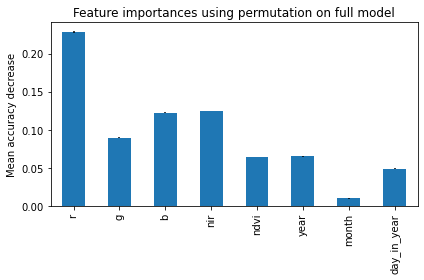

In [24]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [2]:
import pystac_client 
import planetary_computer as pc

def get_item_from_id(itemid):
    # accesing Azure storage using pystac client
    URL = "https://planetarycomputer.microsoft.com/api/stac/v1"
    catalog = pystac_client.Client.open(URL)

    search = catalog.search(
        collections=["naip"],
        ids = itemid)
    
    item = list(search.get_items())[0]
    # sign and open item
    return item

import calendar

def day_in_year(day,month,year):
    days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
    n = 0
    for i in range(0,month-1):
        n = n+days_in_month[i]
    n = n+day
    if calendar.isleap(year) and month>2:
        n = n+1
    return n

In [3]:
aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
cp = aois.iloc[0]
cp

name                                             campus point
itemid               ca_m_3411934_sw_11_060_20180722_20190209
geometry    POLYGON ((-119.8534713523 34.4028697719, -119....
Name: 0, dtype: object

In [6]:
image = ipf.open_window_in_scene(cp.itemid, cp.geometry)
item = get_item_from_id(cp.itemid)

veg = ipf.select_ndvi_df(image)
    
veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))

veg['year'] = item.datetime.year
veg['month'] = item.datetime.month
veg['day_in_year'] = day_in_year(item.datetime.day, item.datetime.month, item.datetime.year)
    
veg = veg[['r','g','b','nir','ndvi','year','month','day_in_year']] # order features

veg.head(4)

/home/jovyan/msai4earth-esa/iceplant_detection/iceplant_detection_functions.py:208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vegetation.drop(labels=['ndvi'],axis=1, inplace=True)
/tmp/ipykernel_1016/2762087977.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  veg['ndvi']=(veg.nir.astype('int16') - veg.r.astype('int16'))/(veg.nir.astype('int16') + veg.r.astype('int16'))
/tmp/ipykernel_1016/2762087977.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See 

,r,g,b,nir,ndvi,year,month,day_in_year
18,33,43,62,37,0.057143,2018,7,203
24,116,105,108,135,0.075697,2018,7,203
25,114,104,103,146,0.123077,2018,7,203
26,118,108,110,153,0.129151,2018,7,203


In [12]:
index = veg.index
features = np.array(veg)

predictions_class = rfc.predict(features)
c = {'prediction': predictions_class}
predictions_df = pd.DataFrame(c, index = index)
    
predictions = ipf.predictions_backto_image(image,predictions_df)



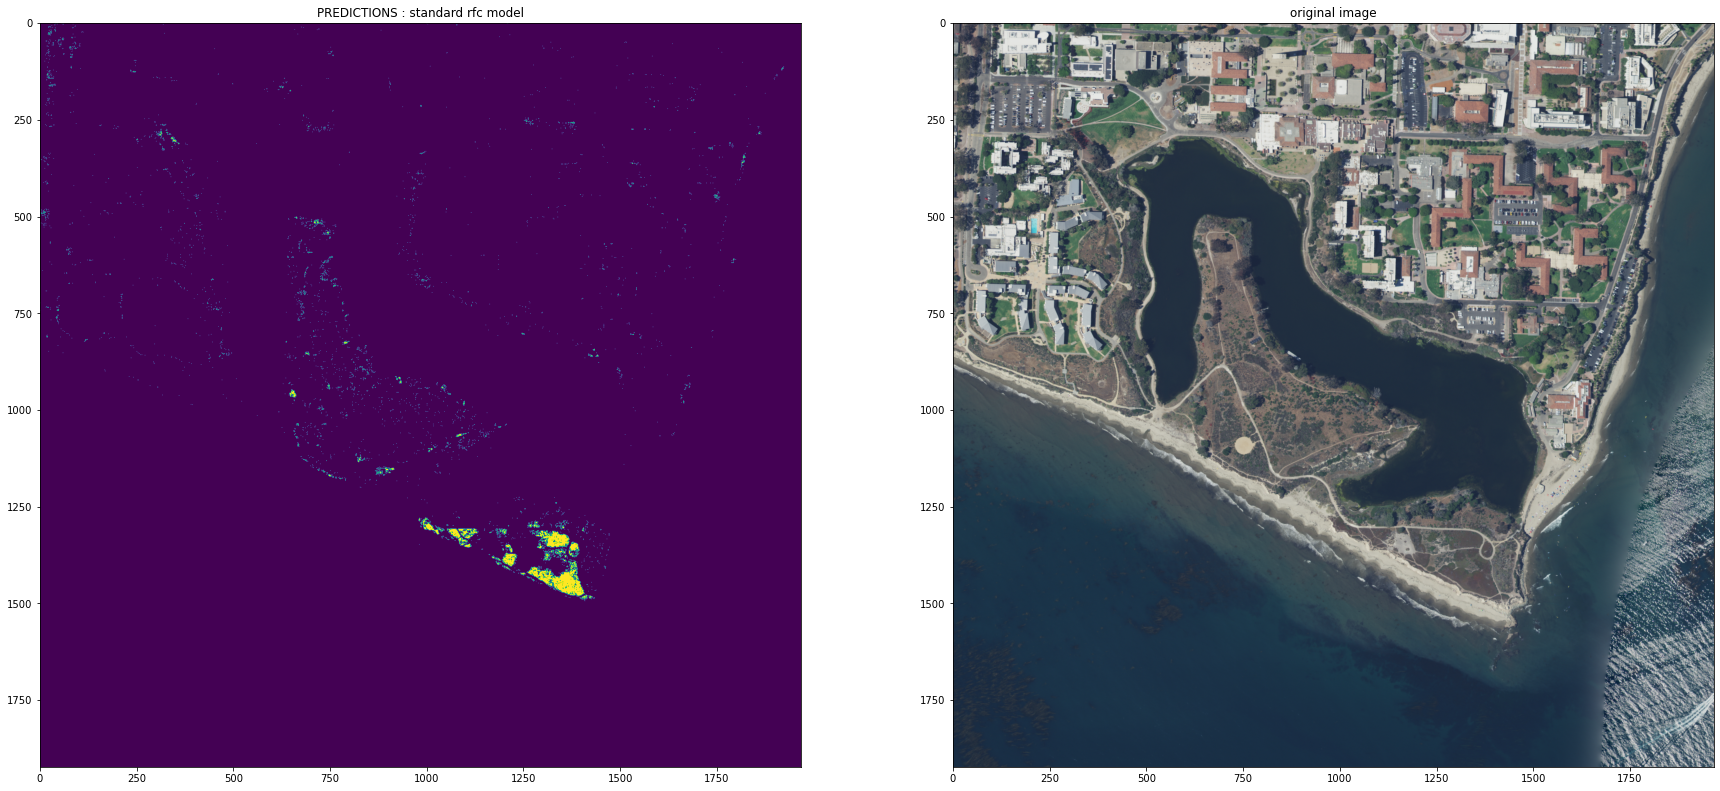

In [15]:
original = np.moveaxis(ipf.rgb_window_in_scene(cp.itemid, cp.geometry),0,-1)
fig, ax = plt.subplots(1,2,figsize=(30, 40))

ax[0].imshow(predictions)
ax[0].set_title("PREDICTIONS : standard rfc model")

ax[1].imshow(original)
ax[1].set_title("original image")

plt.show()